In [316]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time

plt.rcParams.update({'font.size': 16})
from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi

from utilities import GS,smoothing, restriction, residual,prolongation


import matplotlib.animation as animation

from IPython import display
from matplotlib.animation import PillowWriter
metadata = dict(title='Movie', artist='cong')
# writer = PillowWriter(fps=15, metadata=metadata)
writer = PillowWriter(fps=15, metadata=metadata)

In [317]:
def CFL(ux,dx,uy=None,dy=None):
    # A function defines Courant, Friedrichs, and Lewy or Courant number or the CFL number
    
    # if dy is not provided, means the problem is 1D
    if dy == None:
        CFL = dx/ux
    else:
        CFL = 1/ (ux/dx + uy/dy)
    return CFL

In [318]:
def applyIC(phi, Nx, dx):
    # A function to apply specified initial conditions at t=0.
    """
    phi: the dependent variables
    Nx: number of grids
    dx: Grid size
    """
    
    x = np.arange(0,1+dx,dx)
    
    for i in range(x.shape[0]):
        if 0<=x[i]<=0.5:
            phi[i] = 2*x[i]
        elif 0.5<=x[i]<=1:
            phi[i] = 2-2*x[i]
    
    phi[0],phi[-1] = 0,0
    return phi


def prepare_phi(Nx, dx):
    # A function to generate variable 'phi' with ICs
    """
    Nx: number of grids
    dx: Grid size
    """
    phi = np.zeros((Nx))
    
    phi = applyIC(phi, Nx, dx)

    return phi

In [319]:
def alpha1(x):
    # A function for calculate alpha for very first time step based on the ICs
    if 0<=x<=0.5:
        a = 2*x
    elif 0.5<=x<=1:
        a = 2-2*x
    return a

In [320]:
def GS(phi, RHS,aE,aW,a00,Nx,tol):
    # A function to perform 1D Gauss-Siedel algorithm

    for _ in tqdm(range(100000)):
        for i in range(1,Nx-1):
            # Gauss-Siedel Update
            phi[i] = (RHS[i] - aE*phi[i+1] - aW*phi[i-1]) / a00
            
        # Calculate residual
        R2 = 0
        R = np.zeros(Nx)

        for i in range(1,Nx-1):    
            R[i] = RHS[i] - aE*phi[i+1] - aW*phi[i-1]  - a00*phi[i]
            R2 = R2+R[i]**2

        R2 = np.sqrt(R2)
        if _ %5000==0:
            clear_output(True)
            print('Residual:', R2)
            
        if R2<tol:
            print('Converged! Residual: ',R2)

            break
    return phi


In [321]:
Nx = 41
L = 1  # length

dx = L / (Nx - 1)  # Grid size

# Wave speed in x-direction
ux = 1

# tolerance for convergence
tol = 1e-6

# cfl number
cfl = CFL(ux,dx)


dt = 0.4 * cfl

phi = prepare_phi(Nx, dx)


In [322]:
# nodal equations
aE = -ux**2/dx**2
aW = -ux**2/dx**2

# a00 for first time step
a00 = 2/dt**2 + 2*ux**2/dx**2

# a0 for the rest of time steps
a0 = 1/dt**2 + 2*ux**2/dx**2

# beta is the ICs for d𝜙/dt @ t=0. In this problem, beta is 0
beta = 0

# number of time steps
num_n =20

# For every time step, re-calculate the RHS terms at all nodes based on equation provided in text book
# 𝜙 = 𝜙 @ |n time steps|
# 𝜙_old = 𝜙 @ |n-1|, used for n>0
for n in range(num_n):

    if n ==0: 
        phi_old = phi

        # Calculate RHS
        RHS = np.zeros(phi.shape)
        for i in range(Nx):
            x = dx*i
            alpha = alpha1(x)
            RHS[i] = 2/dt**2 * (alpha + dt * beta)

        # GS update
        phi = GS(phi, RHS,aE,aW,a00,Nx,tol)
        
            
    else:

        # Calculate RHS
        RHS = np.zeros(phi.shape)
        for i in range(Nx):
            x = dx*i
            RHS[i] = 1/dt**2 * (2*phi[i] - phi_old[i])

        # GS update
        phi = GS(phi, RHS,aE,aW,a0,Nx,tol)

        # Update 𝜙_old = 𝜙 @ |n-1| for next time step
        phi_old = phi
print('Finished at time: ',n*dt)   

  0%|          | 8/100000 [00:00<00:13, 7627.74it/s]

Residual: 7.5444644863149986
Converged! Residual:  9.41264359674563e-07
Finished at time:  0.19000000000000003


In [323]:
# Analytical solution
x = np.linspace(0, 1, Nx)
phi_A = np.zeros((Nx))
tmp = np.zeros(Nx)
for n in range(num_n):
    t = n * dt
    if n>0:
        for i in range(Nx):
            tmp[i] += np.sin(n * np.pi / 2) / n ** 2 * np.cos(n * np.pi * t) * np.sin(n * np.pi * x[i])

for i in range(Nx):
    phi_A[i] = 8 / np.pi ** 2 * tmp[i]

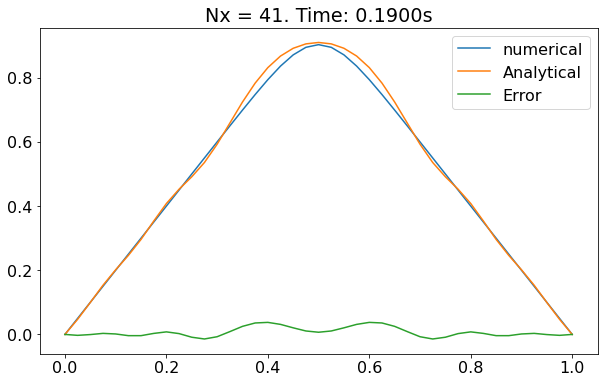

In [324]:
title = 'Nx = '+str(Nx) + '. Time: '+str(n * dt)[:6]+'s'
xx = np.linspace(0,L,phi.shape[0])
plt.figure(figsize=(10,6))
plt.plot(xx,phi,label='numerical')
plt.plot(xx,phi_A,label='Analytical')
plt.plot(xx,phi_A-phi,label='Error')

plt.title(title)
plt.legend()